# Forward Simulation of 2D VEP model at Source level

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [4]:
cwd = os.getcwd()
cwd

'/data/VEP_benchmark/VEP_Optimization_Benchmark'

In [5]:
Res_dir='data_output_files'

In [6]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

# Patient CJ

## Structural Connectivity and Gain Matrices

In [7]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData/connectivity", "weights.txt"))

In [8]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [9]:
weights.min(), weights.max()

(0.0, 1.0)

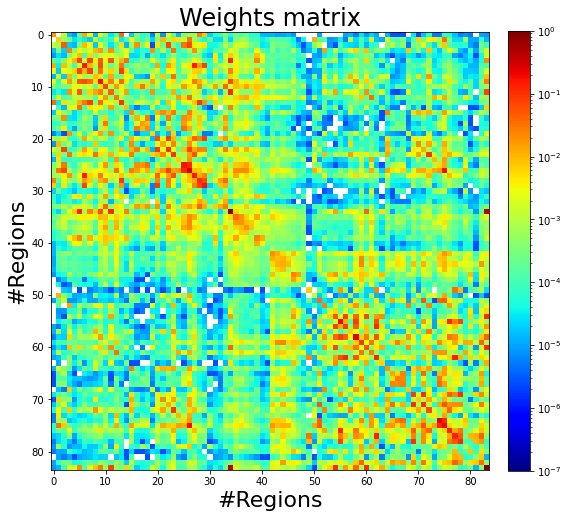

In [10]:
plt.figure(figsize=(8, 8))

norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Weights matrix', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)
plt.tight_layout()
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [11]:
# here we set the ground-truth

hz_val=-3.5 
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_idx = np.array([5, 11, 27],  dtype=np.int32)

In [12]:
nn=84

In [13]:
hz_idx=np.array(list(set(np.r_[0:nn])-set(ez_idx)-set(pz_idx)))

In [14]:
#Here, we increase manually the weights between EZ and PZ to get propagation:
weights[np.ix_(np.array([5,11]), ez_idx)] = 4.0
weights[np.ix_(np.array([27]), ez_idx)] = 1.0

In [15]:
# SC is given to simulator as fixed values (at the end we use this matrix to connect the nodes.) 
SC=weights
SC.shape

(84, 84)

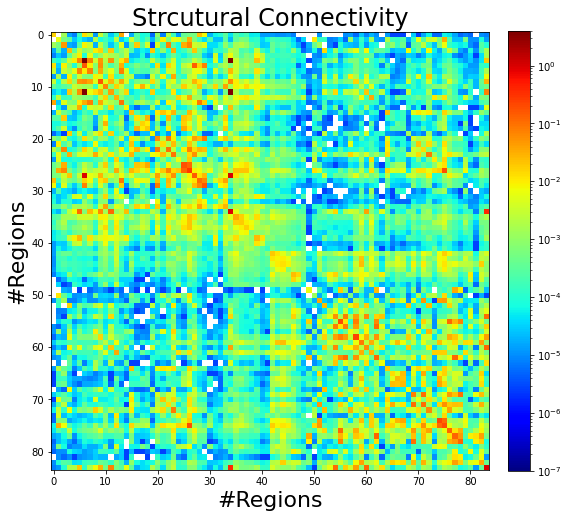

In [16]:
plt.figure(figsize=(8, 8))
norm = colors.LogNorm(1e-7, SC.max())
im = plt.imshow(SC,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Strcutural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)
plt.tight_layout()
plt.show()

### Simulator

In [17]:
@jit(nopython=False) 
def VEP2Dmodel(params, constants, init_conditions, SC, dt, ts):
    
    nt=ts.shape[0]
    nn=SC.shape[0]
    
    #parameters
    eta=params[0:nn]
    K=params[-1]
    
    # fixed parameters
    tau0, I1, sigma=constants[0], constants[1], constants[2]


    # simulation from initial point
    x = np.zeros((nn, nt))  # fast voltage
    z = np.zeros((nn, nt))  # slow voltage

    # initial conditions
    x_init, z_init=init_conditions[0], init_conditions[1]
    for i in range(0, nn):
          x[i, 0] = x_init
          z[i, 0] = z_init
    

    # integrate ODE
    for t in range(0, nt-1):
        for i in range(0, nn):
            gx = 0;
            for j in range(0, nn):
                    gx = gx + SC[i, j]*(x[j, t] - x[i, t]);
            dx = 1.0 -  np.power(x[i, t], 3) - 2.0*np.power(x[i, t], 2) - z[i, t] + I1;
            dz = (1./tau0)*(4.*(x[i, t] - eta[i]) - z[i, t] - K*gx);
            x[i, t+1] = x[i, t] + dt*dx + np.sqrt(dt) * sigma * np.random.randn() 
            z[i, t+1] = z[i, t] + dt*dz + np.sqrt(dt) * sigma * np.random.randn()  
  
    
    return np.concatenate((x.reshape(-1) , z.reshape(-1) )) 

### A simulations for  sanity check

In [18]:
T = 14.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [19]:
nt=ts.shape[0]
nt

141

In [20]:
nn=SC.shape[0]
nn

84

In [21]:
tau0=10.
I1=3.1    
sigma=0. # we assume ODE so no noise in the system
constants = np.array([tau0, I1, sigma])

In [22]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [23]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [24]:
K_true=1. # global copuling parameters

In [25]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [26]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, SC, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.9954376220703125


In [27]:
start_time = time.time()
Sim_true = VEP2Dmodel(params_true, constants, init_conditions, SC, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.003093242645263672


In [28]:
Sim_true.shape

(23688,)

In [29]:
# Sim_source=Sim.reshape(nn, int(Sim.shape[0]/(nn)))
# Sim_source.shape

# X=Sim_source[:,0:nt]
# Z=Sim_source[:,nt:2*nt]

In [30]:
X_true=Sim_true[0:nn*nt].reshape(nn, nt)
Z_true=Sim_true[nn*nt:2*nn*nt].reshape(nn, nt)

In [31]:
X_true.shape, Z_true.shape

((84, 141), (84, 141))

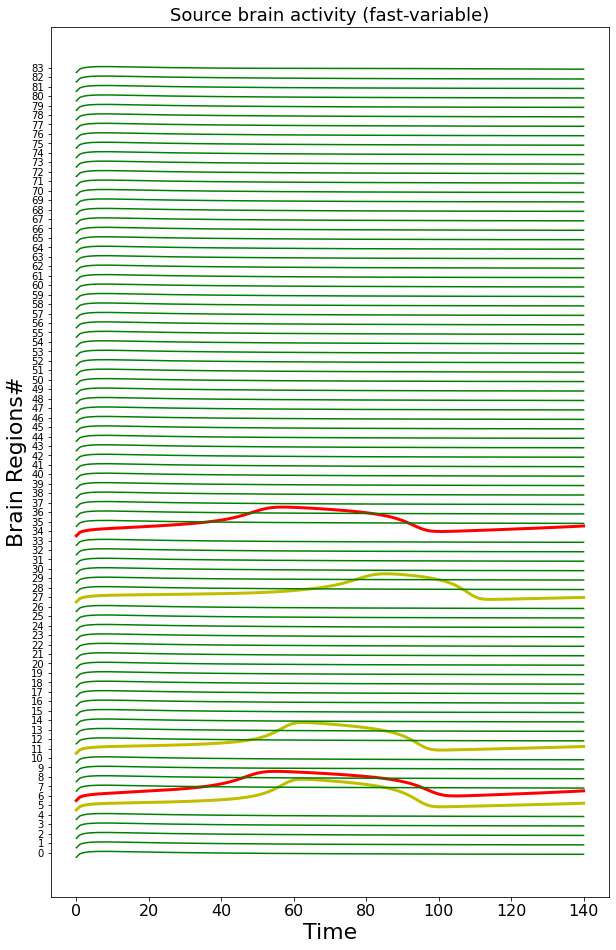

In [32]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X_true[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X_true[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X_true[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity (fast-variable)",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

# Objective function

In [33]:
nn

84

In [34]:
X_true.shape

(84, 141)

In [35]:
X_obs=X_true

In [36]:
prior_range_K=np.arange(0,2,0.04).reshape(1,-1)

prior_range_eta_=np.arange(-5,0,0.1).reshape(1,-1)
prior_range_eta = np.repeat(prior_range_eta_, repeats=nn, axis=0)


prior_range_K.shape, prior_range_eta.shape

((1, 50), (84, 50))

In [37]:
prior_range=np.vstack([prior_range_eta, prior_range_K])
prior_range.shape

(85, 50)

In [38]:
params_true=np.append(eta_true, K_true)
params_true

array([-3.5, -3.5, -3.5, -3.5, -3.5, -2.4, -1.6, -3.5, -3.5, -3.5, -3.5,
       -2.4, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -2.4, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -1.6, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,  1. ])

In [39]:
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 

In [40]:
from matplotlib import gridspec
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((0, 2))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((0, 2))
    acq.set_ylim((-25, np.max(utility) + 1.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [41]:
params_true

array([-3.5, -3.5, -3.5, -3.5, -3.5, -2.4, -1.6, -3.5, -3.5, -3.5, -3.5,
       -2.4, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -2.4, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -1.6, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,  1. ])

In [42]:
def black_box_function(eta_ez1, eta_ez2, eta_pz1, eta_pz2, eta_pz3, K):
    
    eta_propsal=eta_true
    eta_propsal[ez_idx[0]]=eta_ez1
    eta_propsal[ez_idx[1]]=eta_ez2
    eta_propsal[pz_idx[0]]=eta_pz1
    eta_propsal[pz_idx[1]]=eta_pz2
    eta_propsal[pz_idx[2]]=eta_pz3

    K_propsal=K
    
    params_val=np.append(eta_propsal, K_propsal)
    Sim =VEP2Dmodel(params_val, constants, init_conditions, SC, dt, ts)
    X_model=Sim[0:nn*nt].reshape(nn, nt)

    return -1*np.sqrt(np.sum((X_model-X_obs)**2))

In [43]:
bounds_eta = np.array([[-4., -1.]])
bounds_K = np.array([[0., 2.0]])

In [44]:
eta_ = np.linspace(bounds_eta[:, 0], bounds_eta[:, 1], 400).reshape(-1, 1)
K_ = np.linspace(bounds_K[:, 0], bounds_K[:, 1], 400).reshape(-1, 1)

eta_.shape, K_.shape

((400, 1), (400, 1))

In [45]:
pbounds = {'eta_ez1': (-4, 1) , 'eta_ez2': (-4, 1) , 'eta_pz1': (-4, 1) , 'eta_pz2': (-4, 1) , 'eta_pz3': (-4, 1) , 'K': (0, 2)}
pbounds

{'eta_ez1': (-4, 1),
 'eta_ez2': (-4, 1),
 'eta_pz1': (-4, 1),
 'eta_pz2': (-4, 1),
 'eta_pz3': (-4, 1),
 'K': (0, 2)}

In [46]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

In [47]:
optimizer.maximize(init_points=50,n_iter=50, kappa=100)


|   iter    |  target   |     K     |  eta_ez1  |  eta_ez2  |  eta_pz1  |  eta_pz2  |  eta_pz3  |
-------------------------------------------------------------------------------------------------
| 1         | -31.32    | 0.834     | -0.3984   | -3.999    | -2.488    | -3.266    | -3.538    |
| 2         | -30.84    | 0.3725    | -2.272    | -2.016    | -1.306    | -1.904    | -0.5739   |
| 3         | -35.36    | 0.4089    | 0.3906    | -3.863    | -0.6477   | -1.913    | -1.207    |
| 4         | -41.6     | 0.2808    | -3.009    | 0.003723  | 0.8413    | -2.433    | -0.5384   |
| 5         | -39.76    | 1.753     | 0.473     | -3.575    | -3.805    | -3.151    | 0.3907    |
| 6         | -35.51    | 0.1967    | -1.894    | 0.7894    | -1.334    | -0.5406   | -2.422    |
| 7         | -40.28    | 1.373     | 0.1731    | -3.909    | -0.2493   | 0.9443    | -0.2592   |
| 8         | -37.17    | 0.5609    | -0.0536   | -3.484    | -1.761    | 0.543     | -2.532    |
| 9         | -35.9 

| 51        | -27.18    | 1.92      | -0.8872   | -2.405    | -0.7891   | -1.92     | -2.944    |
| 52        | -15.81    | 0.9522    | -1.757    | -1.588    | -2.841    | -3.227    | -3.896    |
| 53        | -27.82    | 0.5816    | -2.559    | -1.367    | -3.354    | -3.88     | -4.0      |
| 54        | -13.85    | 0.9727    | -1.388    | -1.629    | -2.76     | -2.273    | -4.0      |
| 55        | -19.38    | 1.862     | -1.75     | -1.882    | -3.091    | -2.459    | -4.0      |
| 56        | -24.12    | 0.05576   | -1.354    | -1.564    | -2.225    | -2.69     | -4.0      |
| 57        | -19.03    | 1.225     | -1.505    | -0.7972   | -2.953    | -2.464    | -4.0      |
| 58        | -21.57    | 0.7804    | -1.193    | -1.943    | -3.622    | -2.503    | -4.0      |
| 59        | -17.18    | 1.442     | -1.172    | -1.728    | -2.239    | -2.825    | -4.0      |
| 60        | -18.28    | 1.019     | -1.793    | -1.806    | -2.64     | -2.404    | -3.2      |
| 61        | -20.11

In [48]:
optimizer.maximize(init_points=50,n_iter=50, xi=0.1)

|   iter    |  target   |     K     |  eta_ez1  |  eta_ez2  |  eta_pz1  |  eta_pz2  |  eta_pz3  |
-------------------------------------------------------------------------------------------------
| 101       | -37.89    | 1.624     | 0.3748    | -0.5579   | -1.153    | -3.195    | -1.666    |
| 102       | -34.23    | 0.6903    | -2.875    | -1.037    | -2.439    | 0.5815    | 0.5482    |
| 103       | -34.85    | 0.5142    | -3.446    | -3.035    | -1.502    | -0.3571   | -2.959    |
| 104       | -31.64    | 0.4961    | 0.2584    | -1.921    | -0.9166   | -2.832    | -3.49     |
| 105       | -28.47    | 1.032     | -1.614    | -3.237    | -0.891    | -1.28     | -0.7293   |
| 106       | -36.49    | 0.2891    | -0.2424   | -2.89     | -1.403    | -0.07352  | -3.888    |
| 107       | -49.45    | 0.6487    | 0.3646    | 0.2235    | -1.308    | 0.333     | 0.749     |
| 108       | -41.26    | 1.653     | 0.2706    | -3.506    | -0.7435   | -0.4824   | -0.9488   |
| 109       | -35.06

| 151       | -12.68    | 1.378     | -1.322    | -1.28     | -3.491    | -4.0      | -2.687    |
| 152       | -24.27    | 0.4696    | -1.754    | -0.7892   | -3.896    | -3.956    | -2.22     |
| 153       | -28.46    | 2.0       | -2.814    | -1.886    | 1.0       | -0.8621   | -3.317    |
| 154       | -9.598    | 1.186     | -1.759    | -1.507    | -2.907    | -3.47     | -2.014    |
| 155       | -8.873    | 1.207     | -1.727    | -1.163    | -3.232    | -3.459    | -2.491    |
| 156       | -7.922    | 0.8601    | -1.684    | -1.369    | -2.685    | -3.701    | -2.416    |
| 157       | -19.9     | 0.8513    | -1.913    | -1.693    | -2.622    | -4.0      | -1.988    |
| 158       | -8.735    | 1.001     | -1.405    | -1.333    | -2.6      | -3.237    | -2.41     |
| 159       | -13.88    | 0.7656    | -1.626    | -1.002    | -2.724    | -3.588    | -2.736    |
| 160       | -9.39     | 1.352     | -1.546    | -1.428    | -2.637    | -3.588    | -2.414    |
| 161       | -19.83

In [49]:
print(optimizer.max)

{'target': -6.313386736077071, 'params': {'K': 0.8222596323482192, 'eta_ez1': -1.4494323082821163, 'eta_ez2': -1.5781696236188183, 'eta_pz1': -3.0168047165601775, 'eta_pz2': -3.407087025008626, 'eta_pz3': -2.3686946010466934}}


In [50]:
params_opt=optimizer.max['params']
params_opt

{'K': 0.8222596323482192,
 'eta_ez1': -1.4494323082821163,
 'eta_ez2': -1.5781696236188183,
 'eta_pz1': -3.0168047165601775,
 'eta_pz2': -3.407087025008626,
 'eta_pz3': -2.3686946010466934}

In [51]:
params_true=np.append(eta_true, K_true)
params_true

array([-3.5, -3.5, -3.5, -3.5, -3.5, -4. , -4. , -3.5, -3.5, -3.5, -3.5,
       -4. , -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5,  1. , -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5,  1. , -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,  1. ])

In [52]:
params_est=params_true

In [53]:
params_est[ez_idx[0]]=params_opt['eta_ez1']
params_est[ez_idx[1]]=params_opt['eta_ez2']

params_est[pz_idx[0]]=params_opt['eta_pz1']
params_est[pz_idx[1]]=params_opt['eta_pz2']
params_est[pz_idx[2]]=params_opt['eta_pz3']

params_est[-1]=params_opt['K']

In [54]:
params_est, params_true

(array([-3.5       , -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.01680472, -1.44943231, -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.40708703, -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.5       , -2.3686946 , -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5       , -1.57816962,
        -3.5       , -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5       , -3.5       ,
        -3.5       , -3.5       , -3.5       , -3.5

In [55]:
Sim_est = VEP2Dmodel(params_est, constants, init_conditions, SC, dt, ts)

X_est=Sim_est[0:nn*nt].reshape(nn, nt)
Z_est=Sim_est[nn*nt:2*nn*nt].reshape(nn, nt)

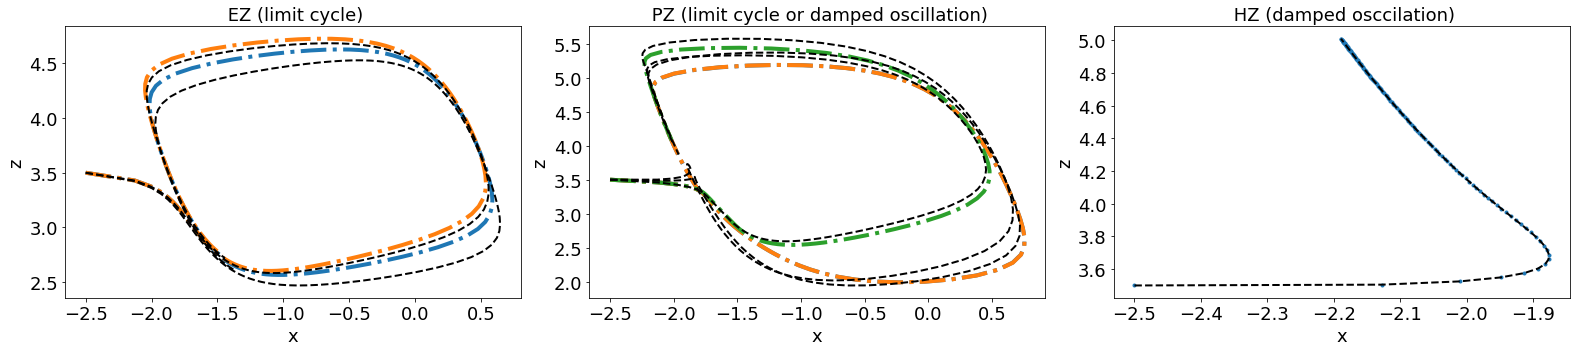

In [56]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, '-.', lw=4);
plt.plot(X_est[ez_idx].T, Z_est[ez_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, '-.', lw=4);
plt.plot(X_est[pz_idx].T, Z_est[pz_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, '.', lw=4);
plt.plot(X_est[1].T, Z_est[1].T, lw=2, color='k',linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.savefig("FittedVEP_limitcycle_Bayesopt.png", dpi=800)
plt.savefig("FittedVEP_limitcycle_Bayesopt.eps", dpi=800)
plt.show()

In [57]:
def f(x):
    eta_propsal=x[0:nn]
    K_propsal=x[-1]
    params_val=np.append(eta_propsal, K_propsal)
    Sim =VEP2Dmodel(params_val, constants, init_conditions, SC, dt, ts)
    X_model=Sim[0:nn*nt].reshape(nn, nt)

    return np.sqrt(np.sum((X_model-X_obs)**2))

In [58]:
bounds_eta = np.array([[-4*ones(nn), -1.0*ones(nn)]]).T[:,:,0]
bounds_K = np.array([[0, 2]])
bounds_eta.shape, bounds_K.shape

((84, 2), (1, 2))

In [59]:
bounds=np.vstack([bounds_eta, bounds_K])
bounds.shape

(85, 2)

In [60]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=2000,         # the number of evaluations of f
                  n_random_starts=2000,  # the number of random initialization points
                  noise=0.0,       # the noise level (optional)
                  random_state=1234)   # the random seed


In [61]:
params_est=res.x

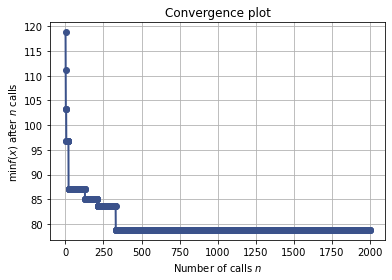

In [62]:
from skopt.plots import plot_convergence
plot_convergence(res);

In [63]:
Sim_est = VEP2Dmodel(params_est, constants, init_conditions, SC, dt, ts)

X_est=Sim_est[0:nn*nt].reshape(nn, nt)
Z_est=Sim_est[nn*nt:2*nn*nt].reshape(nn, nt)

In [64]:
RMSE(np.asarray(params_est), np.asarray(params_true))

1.0682783400073066

In [65]:
nodes=np.r_[0:nn]

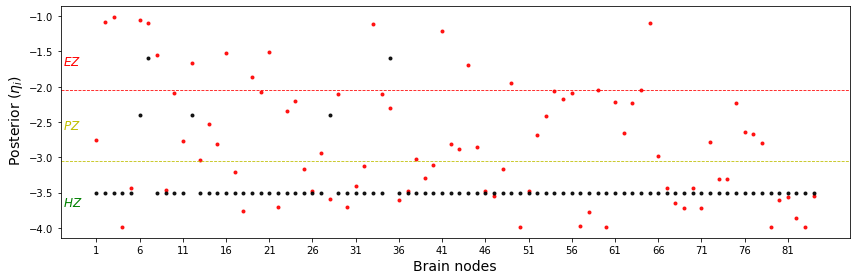

In [66]:
plt.figure(figsize=(12, 4))
plt.plot(nodes+1, params_est[0:nn] ,'o', color='r', alpha=0.9, markersize=3)

plt.plot(ez_idx+1, ez_val*np.ones((len(ez_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(pz_idx+1, pz_val*np.ones((len(pz_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(hz_idx+1, hz_val*np.ones((len(hz_idx))),'o' , color='k', alpha=0.9, markersize=3)
plt.axhline(y=eta_c, linewidth=.8, color = 'r', linestyle='--')
plt.axhline(y=eta_c-delta_eta, linewidth=.8, color = 'y', linestyle='--')
text(-2.85, -1.7, "$EZ$", size=12, color = 'r')
text(-2.85, -2.6, "$PZ$", size=12, color = 'y')
text(-2.85, -3.7, "$HZ$", size=12, color = 'g')
#plt.xticks(np.r_[1:len(nodes)+1], np.r_[1:len(nodes)+1], rotation=90, fontsize=8)  
plt.xticks(np.arange(1,len(nodes)+1, step=5),np.arange(1, len(nodes)+1, step=5), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=14);  
plt.xlabel('Brain nodes', fontsize=14); 
plt.tight_layout()

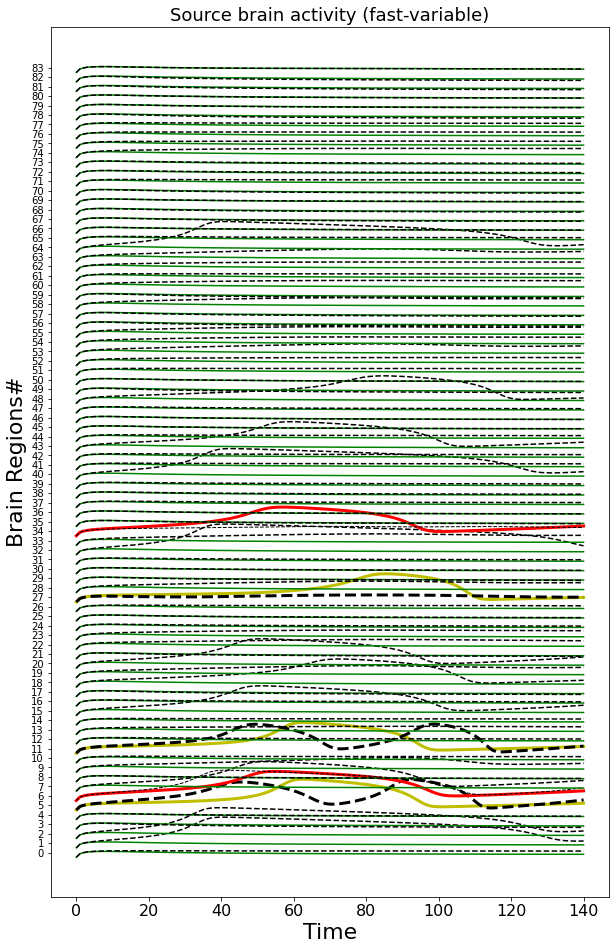

In [67]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X_true[i,:]+i, 'r', lw=3)
          plt.plot(X_est[i,:]+i, 'k--', lw=1)
    elif i in pz_idx:
          plt.plot(X_true[i,:]+i, 'y', lw=3)
          plt.plot(X_est[i,:]+i, 'k--', lw=3)
    else:  
          plt.plot(X_true[i,:]+i, 'g')
          plt.plot(X_est[i,:]+i, 'k--')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity (fast-variable)",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)

plt.savefig("FittedVEP_Bayesopt.png", dpi=800)
plt.savefig("FittedVEP_Bayesopt.eps", dpi=800)

plt.show()

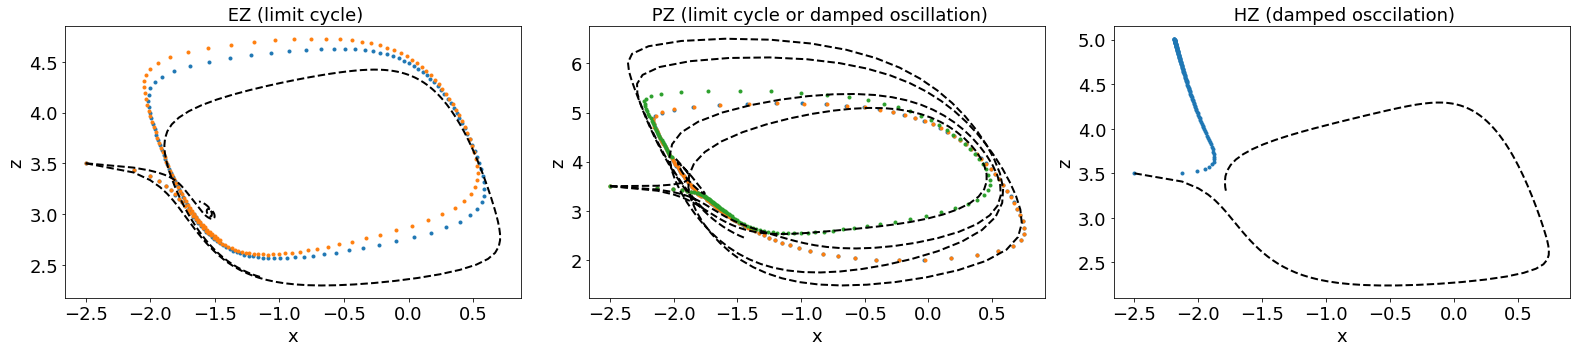

In [68]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, '.', lw=4);
plt.plot(X_est[ez_idx].T, Z_est[ez_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, '.', lw=4);
plt.plot(X_est[pz_idx].T, Z_est[pz_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, '.', lw=4);
plt.plot(X_est[1].T, Z_est[1].T, lw=2, color='k',linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.savefig("FittedVEP_limitcycle_Bayesopt.png", dpi=800)
plt.savefig("FittedVEP_limitcycle_Bayesopt.eps", dpi=800)
plt.show()